In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LogNorm
import seaborn as sns
import re
import ast

In [15]:
def plot_confusion_matrix(cm):
    labels = np.arange(len(cm))
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(cm, annot=False, cmap='Blues', square=True, norm=LogNorm(), xticklabels=labels, yticklabels=labels, ax=ax, cbar=False)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix')
    plt.show()

In [16]:
def cm_metricas(cm):
    #Obtener metricas
    accuracy = np.diag(cm).sum() / cm.sum()
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    f1_score = 2 * precision * recall / (precision + recall)

    #Convertir metricas en porcentajes
    accuracy_percent = np.round(accuracy * 100,2)
    precision_percent = np.round(precision * 100,2)
    recall_percent = np.round(recall * 100,2)
    f1_score_percent = np.round(f1_score * 100,2)
    
    return {
        'Accuracy': np.round(accuracy, 4),
        'Precision': np.round(precision, 4),
        'Recall': np.round(recall, 4),
        'F1 Score': np.round(f1_score, 4)
    }

In [17]:
def convert_string_to_cm(resultados: dict, dataframe: pd.DataFrame):
    for k1 in dataframe.index:
        cm_str = dataframe.loc[k1,'cm']
        
        # Quitar saltos de línea
        cm_str = cm_str.replace('\n', '') 
        # Eliminar todos los corchetes
        cm_str = cm_str.replace('[', '').replace(']', '')

        #Convertir en un arreglo de numpy 
        cm = np.fromstring(cm_str, sep=' ')

        #Convertir cda key del diccionario en su respectivo clave valor con la matriz de confusion
        resultados.setdefault(dataframe.loc[k1, 'name'], {})
        resultados[dataframe.loc[k1, 'name']]['cm'] = cm.reshape((10, 10))

In [18]:
def create_comparison_dataframe(metrics_dict):
    # Crear una lista de DataFrames, uno para cada optimizador
    dfs = []
    for name, metrics in metrics_dict.items():
        columns_dict = {}
        for metric_name, metric_value in cm_metricas(metrics['cm']).items():
            column_name = f"{name} {metric_name}"
            columns_dict[column_name] = metric_value.tolist()[0]
        df = pd.DataFrame(columns_dict)
        dfs.append(df)

    # Concatenar los DataFrames verticalmente
    df = pd.concat(dfs)

    # Dividir las celdas que contienen múltiples valores en varias filas
    df = df.stack().reset_index()
    df = df.rename(columns={'level_0': 'Métricas', 'level_1': 'Optimizador', 0: 'Valor'})

    # Calcular los valores promedio para cada método
    promedios_dict = {}
    for name in metrics_dict.keys():
        promedios_dict[name] = []
        for metric_name in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
            column_name = f"{name} {metric_name}"
            if column_name in df.columns:
                promedio_metrica = df.loc[df['Métricas'] == metric_name, column_name].mean()
            else:
                promedio_metrica = np.nan
            promedios_dict[name].append(promedio_metrica)
    promedios_df = pd.DataFrame(promedios_dict, index=["Promedio Accuracy", "Promedio Precision", "Promedio Recall", "Promedio F1 Score"])

    # Agregar los valores promedio al DataFrame
    df = pd.concat([df, promedios_df], axis=1)

    # Reemplazar los valores NaN con "X"
    df = df.fillna('X')

    # Crear un DataFrame para las 10 filas principales
    top_rows = df.loc[df['Métricas'] != 'Promedio Accuracy']
    top_rows = top_rows.groupby(['Métricas', 'Optimizador'], as_index=False).first()
    top_rows = top_rows.pivot(index='Métricas', columns='Optimizador', values='Valor')
    top_rows = top_rows.reindex(index=['Accuracy', 'Precision', 'Recall', 'F1 Score'], columns=metrics_dict.keys())

    # Crear un DataFrame para las 3 filas de valores promedio
    promedios_rows = df.loc[df['Métricas'].isin(['Promedio Accuracy', 'Promedio Precision', 'Promedio Recall', 'Promedio F1 Score'])]
    promedios_rows = promedios_rows.pivot(index='Métricas', columns='Optimizador', values='Valor')
    promedios_rows = promedios_rows.reindex(index=["Promedio Accuracy", "Promedio Precision", "Promedio Recall", "Promedio F1 Score"], columns = metrics_dict.keys())

    # Concatenar los DataFrames
    df_final = pd.concat([top_rows, promedios_rows])

    # Aplicar formato a las celdas del dataframe
    df_final = df_final.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else x)

    return df_final

# Graficar experimento 1

In [19]:
resultados_df_1 = pd.read_excel('Resultados_Experimento1\\test.xlsx')

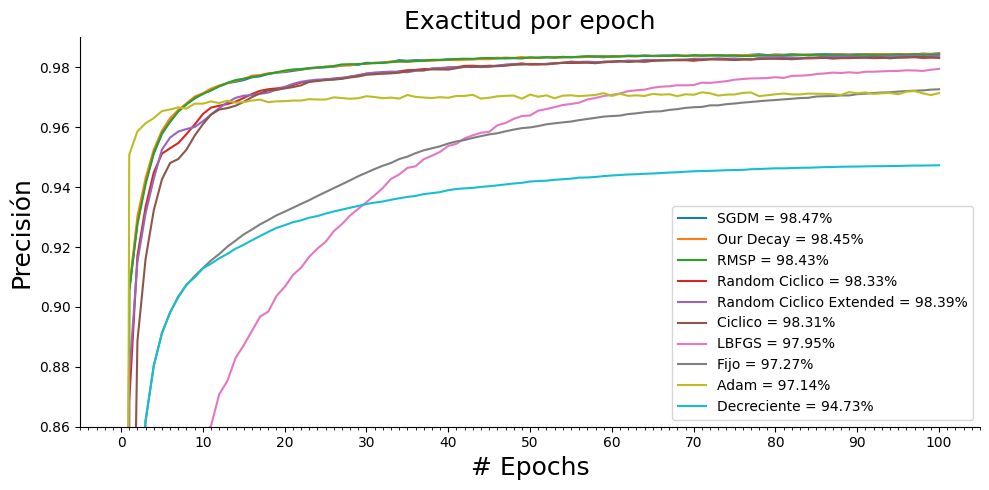

In [20]:
bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))

for k1 in resultados_df_1.index:
    if(resultados_df_1.loc[k1,'name'] not in ["TA Ciclica Aleatoria Decreciente", "TA Ciclica Aleatoria"]):
        lista = [float(x) for x in eval(resultados_df_1.loc[k1,'val_acc_list'])]
        ax.plot(range(len(lista)),
            lista,
            label='{name} = {acc}%'.format(name= resultados_df_1.loc[k1,'name'],
                                        acc = round(lista[-1] * 100 , 2)))

plt.title('Exactitud por epoch', fontsize = 18)

#ax.set_xlim([0, 50])
ax.set_ylim([0.86, 0.990])
#plt.yscale('log')

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Precisión', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)
plt.tight_layout()
plt.show()

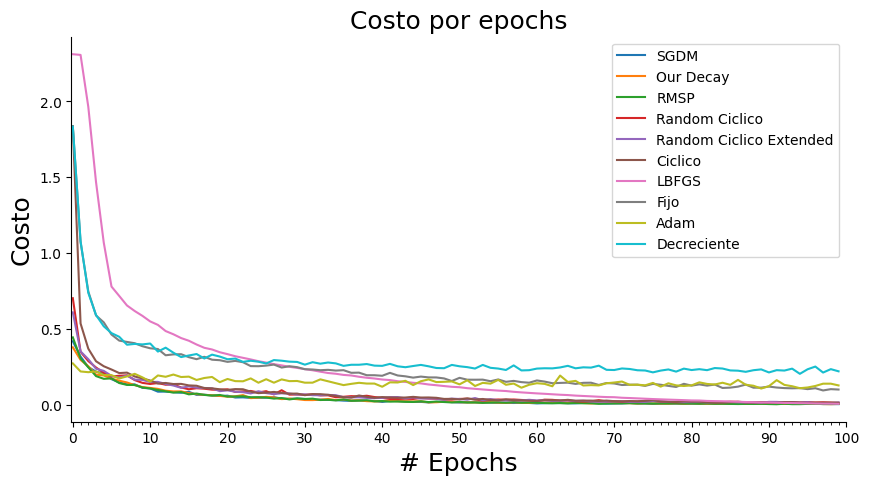

In [21]:
bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))


for k1 in resultados_df_1.index:
    if(resultados_df_1.loc[k1,'name'] not in ["TA Ciclica Aleatoria Decreciente", "TA Ciclica Aleatoria"]):
        lista = [float(x) for x in eval(resultados_df_1.loc[k1,'cost'])]
        ax.plot(range(len(lista)),
            lista,
            label='{name}'.format(name= resultados_df_1.loc[k1,'name']))

plt.title('Costo por epochs', fontsize = 18)

ax.set_xlim([-0.2, 100])

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Costo', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)

plt.show()

In [22]:
resultados1_dic = {}
convert_string_to_cm(resultados1_dic, resultados_df_1)

In [23]:
metrics = []
for key in resultados1_dic.keys():
    metrics.append(cm_metricas(resultados1_dic[key]['cm']))


# Calcular las métricas para cada matriz de confusión

# Crear un DataFrame para mostrar las métricas comparativas
df = pd.DataFrame({'Exactitud SGDM': metrics[0]['Accuracy'], 'Precision SGDM': metrics[0]['Precision'], 'Sensibilidad SGDM': metrics[0]['Recall'], 'F1-Score SGDM': metrics[0]['F1 Score']})
df['Exactitud Our Decay'] = metrics[1]['Accuracy']
df['Precision Our Decay'] = metrics[1]['Precision']
df['Sensibilidad Our Decay'] = metrics[1]['Recall']
df['F1 Score Our Decay'] = metrics[1]['F1 Score']

df['Exactitud RMSP'] = metrics[2]['Accuracy']
df['Precision RMSP'] = metrics[2]['Precision']
df['Sensibilidad RMSP'] = metrics[2]['Recall']
df['F1 Score RMSP'] = metrics[2]['F1 Score']

df['Exactitud Random Ciclico'] = metrics[3]['Accuracy']
df['Precision Random Ciclico'] = metrics[3]['Precision']
df['Sensibilidad Random Ciclico'] = metrics[3]['Recall']
df['F1 Score Random Ciclico'] = metrics[3]['F1 Score']

df['Exactitud Random Ciclico Extended'] = metrics[4]['Accuracy']
df['Precision Random Ciclico Extended'] = metrics[4]['Precision']
df['Sensibilidad Random Ciclico Extended'] = metrics[4]['Recall']
df['F1 Score Random Ciclico Extended'] = metrics[4]['F1 Score']

df['Exactitud Ciclico'] = metrics[5]['Accuracy']
df['Precision Ciclico'] = metrics[5]['Precision']
df['Sensibilidad Ciclico'] = metrics[5]['Recall']
df['F1 Score Ciclico'] = metrics[5]['F1 Score']

df['Exactitud LBFGS'] = metrics[6]['Accuracy']
df['Precision LBFGS'] = metrics[6]['Precision']
df['Sensibilidad LBFGS'] = metrics[6]['Recall']
df['F1 Score LBFGS'] = metrics[6]['F1 Score']

df['Exactitud Fijo'] = metrics[7]['Accuracy']
df['Precision Fijo'] = metrics[7]['Precision']
df['Sensibilidad Fijo'] = metrics[7]['Recall']
df['F1 Score Fijo'] = metrics[7]['F1 Score']

df['Exactitud Adam'] = metrics[8]['Accuracy']
df['Precision Adam'] = metrics[8]['Precision']
df['Sensibilidad Adam'] = metrics[8]['Recall']
df['F1 Score Adam'] = metrics[8]['F1 Score']

df['Exactitud Decreciente'] = metrics[9]['Accuracy']
df['Precision Decreciente'] = metrics[9]['Precision']
df['Sensibilidad Decreciente'] = metrics[9]['Recall']
df['F1 Score Decreciente'] = metrics[9]['F1 Score']

# Calcular las métricas promedio para cada optimizador
promedio_optimizador1 = df.mean(axis=0)[:4].round(decimals=2)
promedio_optimizador2 = df.mean(axis=0)[4:8].round(decimals=2)
promedio_optimizador3 = df.mean(axis=0)[8:12].round(decimals=2)
promedio_optimizador4 = df.mean(axis=0)[12:16].round(decimals=2)
promedio_optimizador5 = df.mean(axis=0)[16:20].round(decimals=2)
promedio_optimizador6 = df.mean(axis=0)[20:24].round(decimals=2)
promedio_optimizador7 = df.mean(axis=0)[24:28].round(decimals=2)
promedio_optimizador8 = df.mean(axis=0)[28:32].round(decimals=2)
promedio_optimizador9 = df.mean(axis=0)[32:36].round(decimals=2)
promedio_optimizador10 = df.mean(axis=0)[36:].round(decimals=2)

# Agregar los valores promedio al DataFrame
df.loc['SGDM'] = promedio_optimizador1
df.loc['Our Decay'] = promedio_optimizador2
df.loc['RMSP'] = promedio_optimizador3
df.loc['Random Ciclico'] = promedio_optimizador4
df.loc['Random Ciclico Extended'] = promedio_optimizador5
df.loc['Ciclico'] = promedio_optimizador6
df.loc['LBFGS'] = promedio_optimizador7
df.loc['Fijo'] = promedio_optimizador8
df.loc['Adam'] = promedio_optimizador9
df.loc['Decreciente'] = promedio_optimizador10


# Reemplazar los valores NaN con 0
df = df.fillna('X')

# Mostrar la tabla de métricas comparativas actualizada
df

,Exactitud SGDM,Precision SGDM,Sensibilidad SGDM,F1-Score SGDM,Exactitud Our Decay,Precision Our Decay,Sensibilidad Our Decay,F1 Score Our Decay,Exactitud RMSP,Precision RMSP,...,Sensibilidad Fijo,F1 Score Fijo,Exactitud Adam,Precision Adam,Sensibilidad Adam,F1 Score Adam,Exactitud Decreciente,Precision Decreciente,Sensibilidad Decreciente,F1 Score Decreciente
0,0.9838,0.9834,0.9915,0.9874,0.9837,0.9833,0.9916,0.9874,0.9837,0.9837,...,0.987,0.9789,0.9687,0.9813,0.9869,0.9841,0.9431,0.9524,0.984,0.9679
1,0.9838,0.9916,0.9925,0.992,0.9837,0.9908,0.9925,0.9917,0.9837,0.9913,...,0.9885,0.9844,0.9687,0.9847,0.9856,0.9852,0.9431,0.9713,0.9817,0.9765
2,0.9838,0.9823,0.9846,0.9835,0.9837,0.9819,0.9846,0.9832,0.9837,0.9822,...,0.9699,0.9712,0.9687,0.9675,0.9723,0.9699,0.9431,0.947,0.9311,0.939
3,0.9838,0.9813,0.9842,0.9827,0.9837,0.9819,0.9833,0.9826,0.9837,0.9821,...,0.9737,0.9683,0.9687,0.9582,0.9703,0.9642,0.9431,0.9272,0.9418,0.9344
4,0.9838,0.9835,0.9825,0.983,0.9837,0.9847,0.9827,0.9837,0.9837,0.9846,...,0.9707,0.9697,0.9687,0.9686,0.9713,0.9699,0.9431,0.9328,0.9492,0.9409
5,0.9838,0.9863,0.98,0.9832,0.9837,0.9853,0.9796,0.9824,0.9837,0.987,...,0.9597,0.9667,0.9687,0.9628,0.9632,0.963,0.9431,0.9444,0.9074,0.9255
6,0.9838,0.9847,0.9851,0.9849,0.9837,0.9833,0.9865,0.9849,0.9837,0.9832,...,0.9721,0.9701,0.9687,0.9778,0.9726,0.9752,0.9431,0.9375,0.9601,0.9486
7,0.9838,0.979,0.9798,0.9794,0.9837,0.9793,0.9792,0.9793,0.9837,0.9782,...,0.9654,0.9654,0.9687,0.9724,0.9643,0.9683,0.9431,0.9471,0.9355,0.9413
8,0.9838,0.9845,0.9798,0.9821,0.9837,0.9853,0.9786,0.9819,0.9837,0.9848,...,0.9605,0.9647,0.9687,0.948,0.9476,0.9478,0.9431,0.932,0.9153,0.9235
9,0.9838,0.9809,0.9765,0.9787,0.9837,0.981,0.9773,0.9791,0.9837,0.9794,...,0.9511,0.9602,0.9687,0.9627,0.9498,0.9562,0.9431,0.9353,0.918,0.9266


In [24]:
df.to_csv('Resultados_Experimento1/tabla_metricas_new.csv', index_label='Clase')

PermissionError: [Errno 13] Permission denied: 'Resultados_Experimento1/tabla_metricas_new.csv'

# Graficar experimento 2

In [25]:
resultados_df_2 = pd.read_excel('Resultados_Experimento_2\Experimento2[05_06_2023-05_58].xlsx')

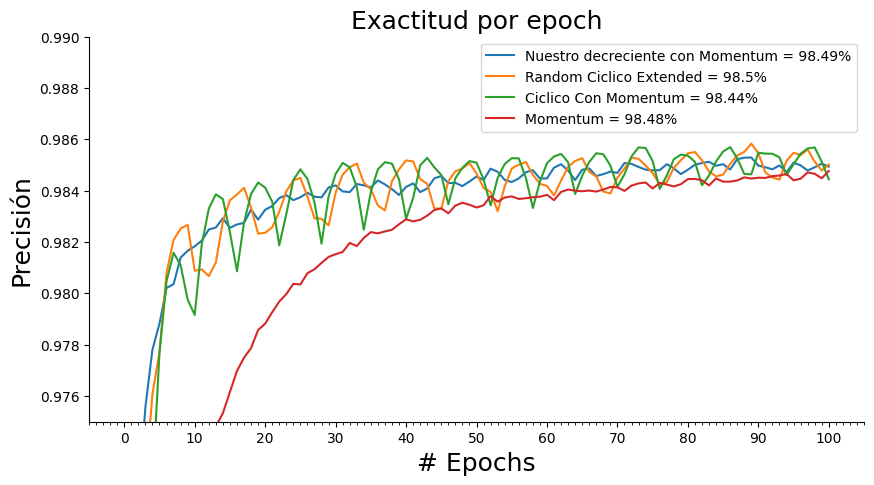

In [26]:
bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))

for k1 in resultados_df_2.index:
    if(resultados_df_2.loc[k1,'name'] not in ["TA Ciclica Aleatoria Decreciente", "TA Ciclica Aleatoria"]):
        lista = [float(x) for x in eval(resultados_df_2.loc[k1,'val_acc_list'])]
        ax.plot(range(len(lista)),
            lista,
            label='{name} = {acc}%'.format(name= resultados_df_2.loc[k1,'name'],
                                        acc = round(lista[-1] * 100 , 2)))

plt.title('Exactitud por epoch', fontsize = 18)

#ax.set_xlim([0, 50])
ax.set_ylim([0.975, 0.990])
#plt.yscale('log')

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Precisión', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)
plt.show()

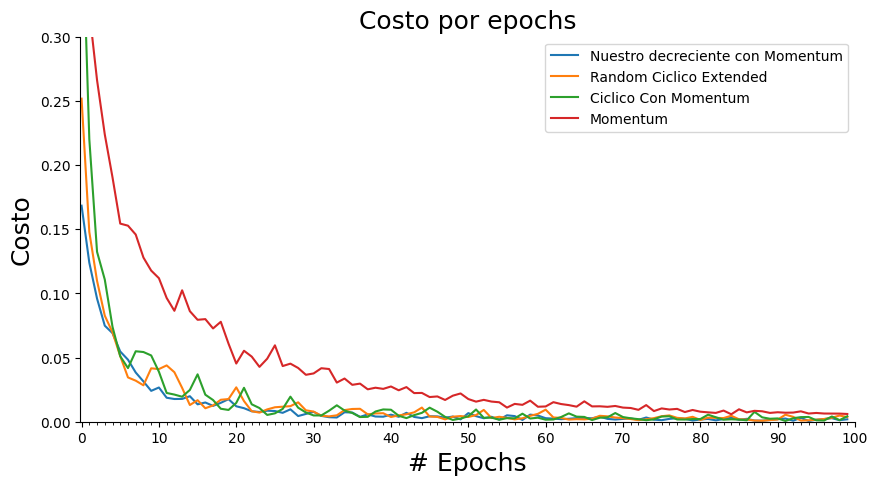

In [27]:
bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))


for k1 in resultados_df_2.index:
    if(resultados_df_2.loc[k1,'name'] not in ["TA Ciclica Aleatoria Decreciente", "TA Ciclica Aleatoria"]):
        lista = [float(x) for x in eval(resultados_df_2.loc[k1,'cost'])]
        ax.plot(range(len(lista)),
            lista,
            label='{name}'.format(name= resultados_df_2.loc[k1,'name']))

plt.title('Costo por epochs', fontsize = 18)

ax.set_ylim([0, 0.3])
ax.set_xlim([-0.2, 100])

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Costo', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)

plt.show()

In [28]:
resultados2_dic = {}
convert_string_to_cm(resultados2_dic, resultados_df_2)

In [30]:
for k in resultados2_dic.keys():
    print(k)

Nuestro decreciente con Momentum
Random Ciclico Extended
Ciclico Con Momentum
Momentum


In [31]:
metrics = []
for key in resultados1_dic.keys():
    metrics.append(cm_metricas(resultados1_dic[key]['cm']))


# Calcular las métricas para cada matriz de confusión

# Crear un DataFrame para mostrar las métricas comparativas
df = pd.DataFrame({'Exactitud Our Decay': metrics[0]['Accuracy'], 'Precision Our Decay Momentum': metrics[0]['Precision'], 'Sensibilidad Our Decay Momentum': metrics[0]['Recall'], 'F1-Score Our Decay Momentum': metrics[0]['F1 Score']})
df['Exactitud Random Ciclico Extendido'] = metrics[1]['Accuracy']
df['Precision Random Ciclico Extendido'] = metrics[1]['Precision']
df['Sensibilidad Random Ciclico Extendido'] = metrics[1]['Recall']
df['F1 Score Random Ciclico Extendido'] = metrics[1]['F1 Score']

df['Exactitud Ciclico Momentum'] = metrics[2]['Accuracy']
df['Precision Ciclico Momentum'] = metrics[2]['Precision']
df['Sensibilidad Ciclico Momentum'] = metrics[2]['Recall']
df['F1 Score Ciclico Momentum'] = metrics[2]['F1 Score']

df['Exactitud Momentum'] = metrics[3]['Accuracy']
df['Precision Momentum'] = metrics[3]['Precision']
df['Sensibilidad Momentum'] = metrics[3]['Recall']
df['F1 Score Momentum'] = metrics[3]['F1 Score']

# Calcular las métricas promedio para cada optimizador
promedio_optimizador1 = df.mean(axis=0)[:4].round(decimals=2)
promedio_optimizador2 = df.mean(axis=0)[4:8].round(decimals=2)
promedio_optimizador3 = df.mean(axis=0)[8:12].round(decimals=2)
promedio_optimizador4 = df.mean(axis=0)[12:].round(decimals=2)

# Agregar los valores promedio al DataFrame
df.loc['Our Decay Momentum'] = promedio_optimizador1
df.loc['Random Ciclico Extended'] = promedio_optimizador2
df.loc['Ciclico Momentum'] = promedio_optimizador3
df.loc['Momentum'] = promedio_optimizador4


# Reemplazar los valores NaN con 0
df = df.fillna('X')

# Mostrar la tabla de métricas comparativas actualizada
df

,Exactitud Our Decay,Precision Our Decay Momentum,Sensibilidad Our Decay Momentum,F1-Score Our Decay Momentum,Exactitud Random Ciclico Extendido,Precision Random Ciclico Extendido,Sensibilidad Random Ciclico Extendido,F1 Score Random Ciclico Extendido,Exactitud Ciclico Momentum,Precision Ciclico Momentum,Sensibilidad Ciclico Momentum,F1 Score Ciclico Momentum,Exactitud Momentum,Precision Momentum,Sensibilidad Momentum,F1 Score Momentum
0,0.9838,0.9834,0.9915,0.9874,0.9837,0.9833,0.9916,0.9874,0.9837,0.9837,0.9912,0.9874,0.9829,0.9809,0.991,0.9859
1,0.9838,0.9916,0.9925,0.992,0.9837,0.9908,0.9925,0.9917,0.9837,0.9913,0.9927,0.992,0.9829,0.9906,0.9927,0.9916
2,0.9838,0.9823,0.9846,0.9835,0.9837,0.9819,0.9846,0.9832,0.9837,0.9822,0.9836,0.9829,0.9829,0.9823,0.9829,0.9826
3,0.9838,0.9813,0.9842,0.9827,0.9837,0.9819,0.9833,0.9826,0.9837,0.9821,0.9831,0.9826,0.9829,0.9812,0.9825,0.9819
4,0.9838,0.9835,0.9825,0.983,0.9837,0.9847,0.9827,0.9837,0.9837,0.9846,0.982,0.9833,0.9829,0.9845,0.9815,0.983
5,0.9838,0.9863,0.98,0.9832,0.9837,0.9853,0.9796,0.9824,0.9837,0.987,0.9798,0.9834,0.9829,0.9853,0.9788,0.9821
6,0.9838,0.9847,0.9851,0.9849,0.9837,0.9833,0.9865,0.9849,0.9837,0.9832,0.9862,0.9847,0.9829,0.9824,0.9848,0.9836
7,0.9838,0.979,0.9798,0.9794,0.9837,0.9793,0.9792,0.9793,0.9837,0.9782,0.98,0.9791,0.9829,0.9789,0.9796,0.9792
8,0.9838,0.9845,0.9798,0.9821,0.9837,0.9853,0.9786,0.9819,0.9837,0.9848,0.9789,0.9818,0.9829,0.9822,0.9771,0.9797
9,0.9838,0.9809,0.9765,0.9787,0.9837,0.981,0.9773,0.9791,0.9837,0.9794,0.978,0.9787,0.9829,0.9796,0.9761,0.9778


In [32]:
df.to_csv('Resultados_Experimento_2/tabla_metricas.csv', index_label='Clase')

# ResNet Graphs

In [62]:
EPOCHS = 50
MAX_ITERATIONS = 5
NUM_CLASSES = 10
resultados = {}

In [63]:
def SumList(first: list, second: list) -> list:
    return [x + y for x, y in zip(first[::-1], second[::-1])][::-1]

def DivideList(dic_list: list, number: int) -> list:
    return [x / number for x in dic_list]

def DeleteZerosFromList(dic_list: list) -> list:
    return list(filter(lambda x: x != 0, dic_list))

In [64]:
def SummarizeResults(result_df: pd.DataFrame, filterStr: str, resultados: dict):
    
    if(filterStr not in resultados):
        resultados[filterStr] = {}
        resultados[filterStr]['val_acc_list'] = [0] * EPOCHS
        resultados[filterStr]['test_acc'] = 0
        resultados[filterStr]['cost'] = [0] * EPOCHS
        resultados[filterStr]['time'] = 0
        resultados[filterStr]['epochs'] = 0

    lr_list = []

    for k1 in result_df.index:
        if(result_df.loc[k1,'name'] == filterStr):

            val_acc_list = [float(x) for x in eval(result_df.loc[k1,'val_acc_list'])]
            acc = (float(result_df.loc[k1,'test_acc'].strip('%')))/100
            cost_list = [float(x) for x in eval(result_df.loc[k1,'cost'])]
            time = result_df.loc[k1,'time']
            epochs = result_df.loc[k1,'epochs']
            lr_list = result_df.loc[k1, 'lr']

            resultados[filterStr]['val_acc_list'] = SumList(resultados[filterStr]['val_acc_list'], val_acc_list)
            resultados[filterStr]['test_acc'] += acc
            resultados[filterStr]['cost'] = SumList(resultados[filterStr]['cost'], cost_list)
            resultados[filterStr]['time'] += time
            resultados[filterStr]['epochs'] += epochs
            resultados[filterStr]['lr'] = lr_list

In [65]:
def AverageResults(filterStr: str, resultados: dict):
    
    resultados[filterStr]['name'] = filterStr
    resultados[filterStr]['test_acc'] = resultados[filterStr]['test_acc'] / MAX_ITERATIONS
    resultados[filterStr]['val_acc_list'] = DeleteZerosFromList(DivideList(resultados[filterStr]['val_acc_list'], MAX_ITERATIONS))
    resultados[filterStr]['cost'] = DeleteZerosFromList(DivideList(resultados[filterStr]['cost'], MAX_ITERATIONS))
    resultados[filterStr]['time'] = resultados[filterStr]['time']/ MAX_ITERATIONS
    resultados[filterStr]['epochs'] = resultados[filterStr]['epochs'] / MAX_ITERATIONS

In [66]:
resultados_df_ex1 = pd.read_excel('Results/Experimento3[04_15_2023-15_01].xlsx')
resultados_df_ex2 = pd.read_excel('Results/Experimento3[04_15_2023-20_41].xlsx')
resultados_df_ex3 = pd.read_excel('Results/Experimento3[04_16_2023-11_28].xlsx')
resultados_df_ex4 = pd.read_excel('Results/Experimento3[04_16_2023-15_16].xlsx')
resultados_df_ex5 = pd.read_excel('Results/Experimento3[04_17_2023-18_36].xlsx')

In [67]:
dfs = [resultados_df_ex1, resultados_df_ex2, resultados_df_ex3, resultados_df_ex4, resultados_df_ex5]
filters = ['TA Ciclica Aleatoria Ext', 'Adam', 'TA Decreciente (propuesta)']

In [68]:
for df in dfs:
    for filterStr in filters:
        SummarizeResults(result_df = df, filterStr = filterStr, resultados = resultados)

for filterStr in filters:
    AverageResults(filterStr=filterStr, resultados=resultados)


In [69]:
resultados_df = pd.DataFrame(resultados.copy()).T

resultados_df['val_acc'] = resultados_df.apply(lambda row: round(row['val_acc_list'][-1]* 100,2), axis=1)
resultados_df['test_acc'] = resultados_df.apply(lambda row: round(row['test_acc']*100,2), axis=1)
# resultados_df['epochs'] = resultados_df.apply(lambda row: len(row['val_acc_list']), axis=1)
# resultados_df['time'] = resultados_df.apply(lambda row: round(row['time']/(100000),2), axis=1)
resultados_df['val_acc'] = resultados_df.apply(lambda row: '{acc}%'.format(acc = row['val_acc']), axis=1)
resultados_df['test_acc'] = resultados_df.apply(lambda row: '{acc}%'.format(acc = row['test_acc']), axis=1)

resultados_df = resultados_df.sort_values(by=['epochs'],ascending=True)

In [70]:
resultados_df = resultados_df.sort_values(by=['epochs'],ascending=True)
resultados_df[['name','epochs','time']].style.hide_index()

C:\Users\denis\AppData\Local\Temp\ipykernel_30824\1229857557.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  resultados_df[['name','epochs','time']].style.hide_index()


name,epochs,time
TA Ciclica Aleatoria Ext,0.000000,2589420.350000
Adam,0.000000,2742108.050000
TA Decreciente (propuesta),0.000000,2139775.200000


In [71]:
resultados_df = resultados_df.sort_values(by=['test_acc'],ascending=False)
resultados_df[['name','val_acc','time','test_acc', 'epochs']].style.hide_index()

C:\Users\denis\AppData\Local\Temp\ipykernel_30824\4194298493.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  resultados_df[['name','val_acc','time','test_acc', 'epochs']].style.hide_index()


name,val_acc,time,test_acc,epochs
TA Ciclica Aleatoria Ext,86.46%,2589420.350000,86.64%,0.000000
Adam,85.58%,2742108.050000,85.95%,0.000000
TA Decreciente (propuesta),60.72%,2139775.200000,60.31%,0.000000


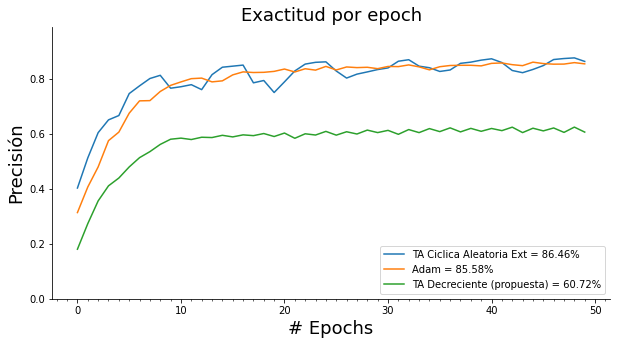

In [72]:
bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))

for k1 in resultados_df.index:
    ax.plot(range(len(resultados_df.loc[k1,'val_acc_list'])),
        resultados_df.loc[k1,'val_acc_list'],
        label='{name} = {acc}%'.format(name= resultados_df.loc[k1,'name'],
                                    acc = round(resultados_df.loc[k1,'val_acc_list'][-1] * 100 , 2)))

plt.title('Exactitud por epoch', fontsize = 18)

#ax.set_xlim([0, 50])
ax.set_ylim([0, 0.990])
#plt.yscale('log')

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Precisión', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)
plt.show()

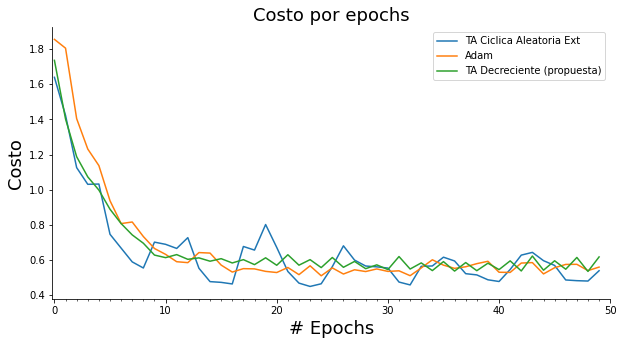

In [73]:
bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))

for k1 in resultados_df.index:
    ax.plot(range(len(resultados_df.loc[k1,'cost'])),
        resultados_df.loc[k1,'cost'],
        label='{name}'.format(name= resultados_df.loc[k1,'name']))

plt.title('Costo por epochs', fontsize = 18)

ax.set_xlim([-0.2, 50])

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Costo', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)

plt.show()

# ResNet Matriz confusion

In [74]:
resultados_res = {}

In [75]:
resultados_df_res_1 = pd.read_excel('Resnet_new/Experimento3[04_26_2023-21_29].xlsx')
resultados_df_res_2 = pd.read_excel('Resnet_new/Experimento3[04_29_2023-11_07].xlsx')
resultados_df_res_3 = pd.read_excel('Resnet_new/Experimento3[04_29_2023-13_28].xlsx')
resultados_df_res_4 = pd.read_excel('Resnet_new/Experimento3[04_29_2023-16_24].xlsx')
resultados_df_res_5 = pd.read_excel('Resnet_new/Experimento3[04_29_2023-19_24].xlsx')

In [76]:
dfs_res = [resultados_df_res_1, resultados_df_res_2, resultados_df_res_3, resultados_df_res_4, resultados_df_res_5]
filters = ['TA Ciclica Aleatoria Ext', 'Adam', 'TA Decreciente (propuesta)']

In [77]:
def SummarizeResults_cm(result_df: pd.DataFrame, filterStr: str, resultados: dict):
    
    if(filterStr not in resultados):
        resultados[filterStr] = {}
        resultados[filterStr]['val_acc_list'] = [0] * EPOCHS
        resultados[filterStr]['test_acc'] = 0
        resultados[filterStr]['cost'] = [0] * EPOCHS
        resultados[filterStr]['time'] = 0
        resultados[filterStr]['epochs'] = 0
        resultados[filterStr]['cm'] = np.zeros((NUM_CLASSES, NUM_CLASSES))

    lr_list = []

    for k1 in result_df.index:
        if(result_df.loc[k1,'name'] == filterStr):

            val_acc_list = [float(x) for x in eval(result_df.loc[k1,'val_acc_list'])]
            acc = (float(result_df.loc[k1,'test_acc'].strip('%')))/100
            cost_list = [float(x) for x in eval(result_df.loc[k1,'cost'])]
            time = result_df.loc[k1,'time']
            epochs = result_df.loc[k1,'epochs']
            lr_list = result_df.loc[k1, 'lr']
            cm_str = result_df.loc[k1, 'cm']

            # Obtener la cadena de texto
            cm_str = cm_str.replace(".", ",")
            # Utilizar expresiones regulares para eliminar caracteres que no sean números, puntos o comas
            cm_str = re.sub("[^0-9.,]+", "", cm_str)

            print(cm_str)

            # Utilizar ast.literal_eval() para convertir la cadena a un array de numpy
            cm_matrix = np.array(ast.literal_eval(cm_str))

            # Utilizar reshape() para cambiar la forma del arreglo a (10,10)
            cm_matrix = cm_matrix.reshape(10, 10)
            cm_matrix = cm_matrix.astype('float64')

            resultados[filterStr]['val_acc_list'] = SumList(resultados[filterStr]['val_acc_list'], val_acc_list)
            resultados[filterStr]['test_acc'] += acc
            resultados[filterStr]['cost'] = SumList(resultados[filterStr]['cost'], cost_list)
            resultados[filterStr]['time'] += time
            resultados[filterStr]['epochs'] += epochs
            resultados[filterStr]['lr'] = lr_list
            resultados[filterStr]['cm'] += cm_matrix

In [78]:
def AverageResults_cm(filterStr: str, resultados: dict):
    
    resultados[filterStr]['name'] = filterStr
    resultados[filterStr]['test_acc'] = resultados[filterStr]['test_acc'] / MAX_ITERATIONS
    resultados[filterStr]['val_acc_list'] = DeleteZerosFromList(DivideList(resultados[filterStr]['val_acc_list'], MAX_ITERATIONS))
    resultados[filterStr]['cost'] = DeleteZerosFromList(DivideList(resultados[filterStr]['cost'], MAX_ITERATIONS))
    resultados[filterStr]['time'] = resultados[filterStr]['time']/ MAX_ITERATIONS
    resultados[filterStr]['epochs'] = resultados[filterStr]['epochs'] / MAX_ITERATIONS
    resultados[filterStr]['cm'] = resultados[filterStr]['cm'] / MAX_ITERATIONS
    resultados[filterStr]['cm'] = resultados[filterStr]['cm'].round(2)

In [79]:
def plot_confusion_matrix(cm, title:str):
    labels = np.arange(len(cm))
    fig, ax = plt.subplots(figsize=(7, 7))
    
    # Graficar la matriz de confusión sin normalizar
    sns.heatmap(cm,fmt= ".0f", annot=True, cmap='Blues', square=True, xticklabels=labels, yticklabels=labels, ax=ax, cbar=True)

    ax.set_xlabel('Valor predicho')
    ax.set_ylabel('Valor real')
    ax.set_title(title)
    
    # Calcular precisión, exhaustividad, sensibilidad y especificidad por clase
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    
    # Imprimir las métricas por clase
    for i in labels:
        print("Clase {}: precision = {:.4f}, Recall = {:.4f}".format(i, precision[i], recall[i]))
    
    plt.show()


In [80]:
for df in dfs_res:
    for filterStr in filters:
        SummarizeResults_cm(result_df = df, filterStr = filterStr, resultados = resultados_res)

for filterStr in filters:
    AverageResults_cm(filterStr=filterStr, resultados=resultados_res)

402,1,44,7,5,0,9,4,23,6,5,452,2,1,2,1,2,0,10,26,7,0,459,7,21,8,13,5,2,0,7,2,45,312,33,49,29,6,2,4,7,0,39,5,445,4,14,2,5,1,2,0,37,48,17,388,8,7,3,2,2,0,25,9,13,4,429,0,3,1,2,0,21,8,27,9,5,424,0,3,15,2,4,1,1,1,0,1,457,3,7,11,4,1,1,2,2,0,14,441,
436,9,24,4,3,1,0,0,20,4,0,487,0,0,0,1,1,0,5,7,11,2,453,11,10,19,5,4,4,3,6,2,26,354,11,69,6,8,5,2,7,1,32,20,420,23,4,10,5,0,3,2,18,22,5,452,0,9,0,1,3,2,32,27,6,14,393,2,5,2,10,1,13,7,4,19,0,444,1,0,19,9,2,0,0,0,0,0,453,2,10,40,0,0,2,1,0,0,5,425,
393,14,20,9,11,5,5,3,33,8,5,457,3,4,1,3,4,1,12,11,32,2,333,47,24,28,41,11,3,1,7,6,24,318,14,71,37,8,4,0,19,1,35,51,322,31,37,20,6,0,11,4,21,88,10,340,23,12,2,1,1,4,16,37,6,9,411,0,1,1,9,11,10,31,17,44,6,366,1,4,25,12,7,13,1,3,1,3,418,2,20,90,5,13,1,7,10,3,10,324,
425,5,6,11,10,1,0,12,19,12,2,476,0,0,2,0,0,0,2,19,20,1,405,24,29,17,11,9,5,1,3,2,7,386,23,46,8,11,2,1,5,1,12,23,449,7,8,14,3,0,3,0,11,62,13,399,1,20,2,1,5,0,8,25,18,11,416,1,2,0,2,0,2,9,10,5,1,469,1,0,10,4,0,3,1,0,0,1,459,7,5,18,0,4,1,0,1,0,4,450,


In [81]:
resultados_df_res = pd.DataFrame(resultados_res.copy()).T

resultados_df_res['val_acc'] = resultados_df_res.apply(lambda row: round(row['val_acc_list'][-1]* 100,2), axis=1)
resultados_df_res['test_acc'] = resultados_df_res.apply(lambda row: round(row['test_acc']*100,2), axis=1)
# resultados_df['epochs'] = resultados_df.apply(lambda row: len(row['val_acc_list']), axis=1)
# resultados_df['time'] = resultados_df.apply(lambda row: round(row['time']/(100000),2), axis=1)
resultados_df_res['val_acc'] = resultados_df_res.apply(lambda row: '{acc}%'.format(acc = row['val_acc']), axis=1)
resultados_df_res['test_acc'] = resultados_df_res.apply(lambda row: '{acc}%'.format(acc = row['test_acc']), axis=1)

resultados_df_res = resultados_df_res.sort_values(by=['epochs'],ascending=True)

In [82]:
resultados_df_res = resultados_df_res.sort_values(by=['epochs'],ascending=True)
resultados_df_res[['name','epochs','time']].style.hide_index()

C:\Users\denis\AppData\Local\Temp\ipykernel_30824\711463707.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  resultados_df_res[['name','epochs','time']].style.hide_index()


name,epochs,time
TA Ciclica Aleatoria Ext,0.000000,2602750.200000
Adam,0.000000,2690301.550000
TA Decreciente (propuesta),0.000000,2608533.550000


In [83]:
resultados_df_res = resultados_df_res.sort_values(by=['test_acc'],ascending=False)
resultados_df_res[['name','val_acc','time','test_acc', 'epochs']].style.hide_index()

C:\Users\denis\AppData\Local\Temp\ipykernel_30824\987489454.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  resultados_df_res[['name','val_acc','time','test_acc', 'epochs']].style.hide_index()


name,val_acc,time,test_acc,epochs
TA Ciclica Aleatoria Ext,86.15%,2602750.200000,86.29%,0.000000
Adam,85.44%,2690301.550000,85.92%,0.000000
TA Decreciente (propuesta),75.02%,2608533.550000,74.34%,0.000000


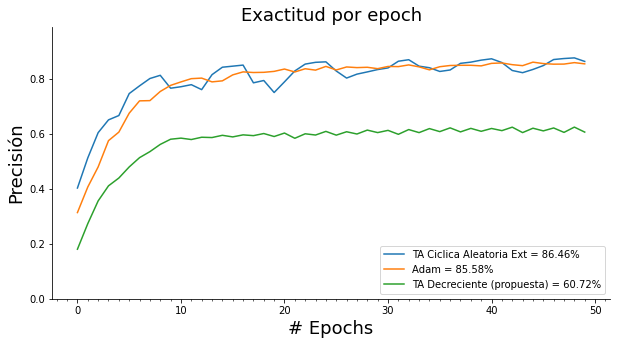

In [84]:
bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))

for k1 in resultados_df.index:
    ax.plot(range(len(resultados_df.loc[k1,'val_acc_list'])),
        resultados_df.loc[k1,'val_acc_list'],
        label='{name} = {acc}%'.format(name= resultados_df.loc[k1,'name'],
                                    acc = round(resultados_df.loc[k1,'val_acc_list'][-1] * 100 , 2)))

plt.title('Exactitud por epoch', fontsize = 18)

#ax.set_xlim([0, 50])
ax.set_ylim([0, 0.990])
#plt.yscale('log')

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Precisión', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)
plt.show()

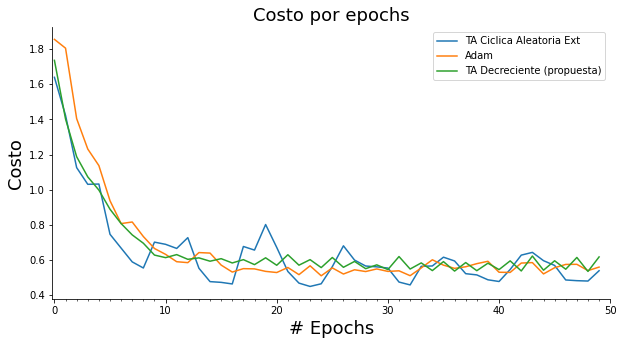

In [85]:
bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))

for k1 in resultados_df.index:
    ax.plot(range(len(resultados_df.loc[k1,'cost'])),
        resultados_df.loc[k1,'cost'],
        label='{name}'.format(name= resultados_df.loc[k1,'name']))

plt.title('Costo por epochs', fontsize = 18)

ax.set_xlim([-0.2, 50])

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Costo', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)

plt.show()

Clase 0: precision = 0.8929, Recall = 0.8455
Clase 1: precision = 0.9297, Recall = 0.9453
Clase 2: precision = 0.7785, Recall = 0.8483
Clase 3: precision = 0.7627, Recall = 0.6994
Clase 4: precision = 0.8259, Recall = 0.8525
Clase 5: precision = 0.8313, Recall = 0.7930
Clase 6: precision = 0.8688, Recall = 0.8856
Clase 7: precision = 0.9073, Recall = 0.9066
Clase 8: precision = 0.9213, Recall = 0.9365
Clase 9: precision = 0.9167, Recall = 0.9201


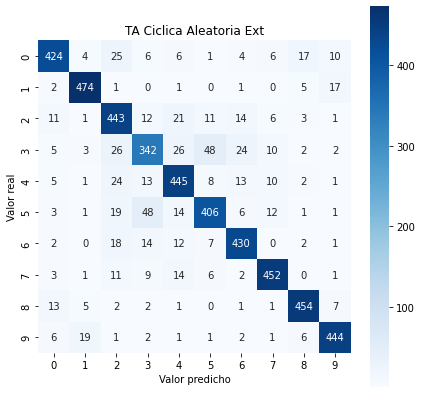

Clase 0: precision = 0.8430, Recall = 0.8982
Clase 1: precision = 0.8923, Recall = 0.9657
Clase 2: precision = 0.8434, Recall = 0.7985
Clase 3: precision = 0.7530, Recall = 0.6982
Clase 4: precision = 0.8895, Recall = 0.8080
Clase 5: precision = 0.7105, Recall = 0.8934
Clase 6: precision = 0.9195, Recall = 0.8317
Clase 7: precision = 0.9333, Recall = 0.8862
Clase 8: precision = 0.9183, Recall = 0.9311
Clase 9: precision = 0.9417, Recall = 0.8836


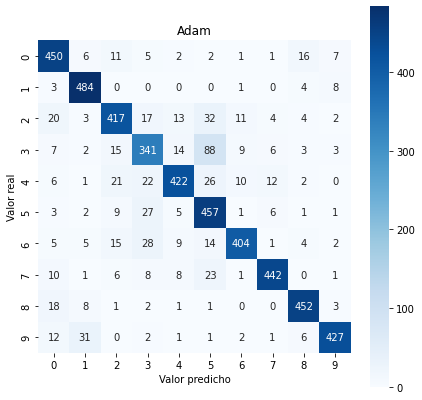

Clase 0: precision = 0.7980, Recall = 0.7429
Clase 1: precision = 0.7979, Recall = 0.9030
Clase 2: precision = 0.6939, Recall = 0.6678
Clase 3: precision = 0.5667, Recall = 0.5227
Clase 4: precision = 0.6833, Recall = 0.7391
Clase 5: precision = 0.6699, Recall = 0.6414
Clase 6: precision = 0.7391, Recall = 0.8300
Clase 7: precision = 0.8284, Recall = 0.7796
Clase 8: precision = 0.7809, Recall = 0.8936
Clase 9: precision = 0.8974, Recall = 0.7209


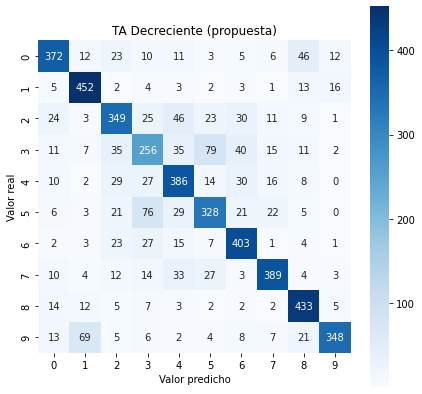

In [261]:
for filterStr in filters:
    plot_confusion_matrix(resultados_res[filterStr]['cm'], filterStr)

In [262]:
print(resultados_res[filters[0]]['cm'])

[[4.236e+02 4.400e+00 2.460e+01 5.600e+00 5.800e+00 6.000e-01 3.600e+00
  5.800e+00 1.720e+01 9.800e+00]
 [2.400e+00 4.736e+02 8.000e-01 4.000e-01 1.000e+00 2.000e-01 6.000e-01
  4.000e-01 5.000e+00 1.660e+01]
 [1.080e+01 8.000e-01 4.428e+02 1.240e+01 2.060e+01 1.120e+01 1.360e+01
  5.600e+00 2.800e+00 1.400e+00]
 [5.000e+00 3.400e+00 2.640e+01 3.420e+02 2.560e+01 4.840e+01 2.440e+01
  9.800e+00 2.000e+00 2.000e+00]
 [5.000e+00 6.000e-01 2.400e+01 1.340e+01 4.450e+02 8.000e+00 1.260e+01
  1.020e+01 2.400e+00 8.000e-01]
 [3.400e+00 1.000e+00 1.900e+01 4.780e+01 1.400e+01 4.060e+02 6.000e+00
  1.240e+01 1.200e+00 1.200e+00]
 [2.400e+00 2.000e-01 1.780e+01 1.400e+01 1.160e+01 6.800e+00 4.304e+02
  4.000e-01 1.600e+00 8.000e-01]
 [2.600e+00 1.000e+00 1.080e+01 9.200e+00 1.360e+01 6.000e+00 1.800e+00
  4.524e+02 4.000e-01 1.200e+00]
 [1.340e+01 5.000e+00 1.600e+00 1.800e+00 8.000e-01 4.000e-01 6.000e-01
  6.000e-01 4.542e+02 6.600e+00]
 [5.800e+00 1.940e+01 1.000e+00 1.800e+00 8.000e-01 8.0

In [263]:
def cm_metricas(cm):
    accuracy = np.diag(cm).sum() / cm.sum()
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    accuracy_percent = np.round(accuracy * 100,2)
    precision_percent = np.round(precision * 100,2)
    recall_percent = np.round(recall * 100,2)
    return [accuracy_percent, precision_percent, recall_percent]

In [264]:
cm1 = resultados_res[filters[0]]['cm']
cm2 = resultados_res[filters[1]]['cm']
cm3 = resultados_res[filters[2]]['cm']

# Calcular las métricas para cada matriz de confusión
metrics1 = cm_metricas(cm1)
metrics2 = cm_metricas(cm2)
metrics3 = cm_metricas(cm3)

# Crear un DataFrame para mostrar las métricas comparativas
df = pd.DataFrame({'Exactitud TA Ciclica Aleatoria Extendida': metrics1[0], 'Precision TA Ciclica Aleatoria Extendida': metrics1[1], 'Recall TA Ciclica Aleatoria Extendida': metrics1[2]})
df['Exactitud Adam'] = metrics2[0]
df['Precision Adam'] = metrics2[1]
df['Sensibilidad Adam'] = metrics2[2]
df['Exactitud TA Decreciente (Propuesta)'] = metrics3[0]
df['Precision TA Decreciente (Propuesta)'] = metrics3[1]
df['Sensibilidad TA Decreciente (Propuesta)'] = metrics3[2]

# Calcular las métricas promedio para cada optimizador
promedio_optimizador1 = df.mean(axis=0)[:3].round(decimals=2)
promedio_optimizador2 = df.mean(axis=0)[3:6].round(decimals=2)
promedio_optimizador3 = df.mean(axis=0)[6:].round(decimals=2)

# Agregar los valores promedio al DataFrame
df.loc['Promedio TA Ciclica Aleatoria Extendida'] = promedio_optimizador1
df.loc['Promedio Adam'] = promedio_optimizador2
df.loc['Promedio TA Decreciente (Propuesta)'] = promedio_optimizador3

# Reemplazar los valores NaN con 0
df = df.fillna('X')

# Mostrar la tabla de métricas comparativas actualizada
df

,Exactitud TA Ciclica Aleatoria Extendida,Precision TA Ciclica Aleatoria Extendida,Recall TA Ciclica Aleatoria Extendida,Exactitud Adam,Precision Adam,Sensibilidad Adam,Exactitud TA Decreciente (Propuesta),Precision TA Decreciente (Propuesta),Sensibilidad TA Decreciente (Propuesta)
0,86.29,89.29,84.55,85.92,84.3,89.82,74.34,79.8,74.29
1,86.29,92.97,94.53,85.92,89.23,96.57,74.34,79.79,90.3
2,86.29,77.85,84.83,85.92,84.34,79.85,74.34,69.39,66.78
3,86.29,76.27,69.94,85.92,75.3,69.82,74.34,56.67,52.27
4,86.29,82.59,85.25,85.92,88.95,80.8,74.34,68.33,73.91
5,86.29,83.13,79.3,85.92,71.05,89.34,74.34,66.99,64.14
6,86.29,86.88,88.56,85.92,91.95,83.17,74.34,73.91,83.0
7,86.29,90.73,90.66,85.92,93.33,88.62,74.34,82.84,77.96
8,86.29,92.13,93.65,85.92,91.83,93.11,74.34,78.09,89.36
9,86.29,91.67,92.01,85.92,94.17,88.36,74.34,89.74,72.09


In [87]:
df.to_csv('tabla_metricas.csv', index_label='Clase')